In [1]:
%cd /home/ubuntu/Qwen-Image-Edit-Angles

/home/ubuntu/Qwen-Image-Edit-Angles


In [2]:
import torch
from matplotlib import pyplot as plt
from pathlib import Path

In [3]:
gen_steps=50

data_dir = Path("/data/model_output_50s")
data_paths = list(data_dir.glob("*.pt"))

data_idx = 0

out_dict = torch.load(data_paths[data_idx])

In [4]:
x_1 = out_dict["noise"]
x_0 = out_dict["output"]
h,w = out_dict["height"], out_dict["width"]
lh,lw = h//16, w//16


ts = []
starts = []
preds = []

for step_idx in range(gen_steps):
    t = out_dict[f"t_{step_idx}"]
    latents_start = out_dict[f"latents_{step_idx}_start"]
    noise_pred = out_dict[f"noise_pred_{step_idx}"]
    ts.append(t)
    starts.append(latents_start)
    preds.append(noise_pred)


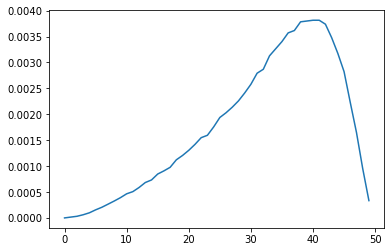

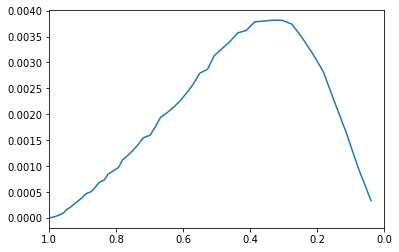

In [5]:
# find x_t_ideal

x_t_ideals = []
for step_idx in range(gen_steps):
    t = ts[step_idx]
    x_t_ideal = (1-t)*x_0 + t * x_1
    x_t_ideals.append(x_t_ideal)

# measure differences between starts and x_t_ideals

diffs = []
for start, x_t_ideal in zip(starts, x_t_ideals):
    diff = (start - x_t_ideal).pow(2).mean()
    diffs.append(diff)



np_ts = [t.float().cpu().numpy() for t in ts]
np_diffs = [d.float().cpu().numpy() for d in diffs]
plt.plot(np_diffs)
plt.show()
plt.plot(np_ts, np_diffs)
plt.xlim(1, 0)
plt.show()

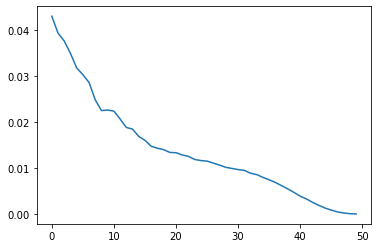

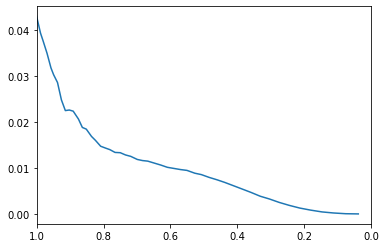

In [6]:
# compare x_0_proj with x_0

x_0_projs = []
proj_diffs = []
for step_idx in range(gen_steps):
    t = ts[step_idx]
    start = starts[step_idx]
    pred = preds[step_idx]
    x_0_proj = start - t * pred
    x_0_projs.append(x_0_proj)
    proj_diff = (x_0 - x_0_proj).pow(2).mean()
    proj_diffs.append(proj_diff)

proj_diffs_np = [d.float().cpu().numpy() for d in proj_diffs]

plt.plot(proj_diffs_np)
plt.show()
plt.plot(np_ts, proj_diffs_np)
plt.xlim(1, 0)
plt.show()

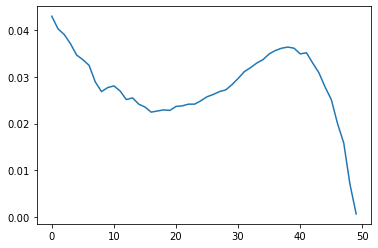

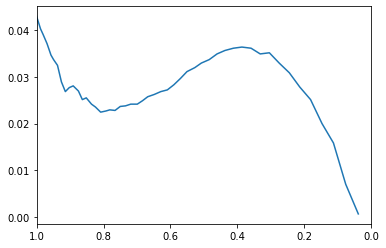

In [7]:
# compare pred with v_ideal

v_ideals = []
v_diffs = []
for step_idx in range(gen_steps):
    t = ts[step_idx]
    start = starts[step_idx]
    pred = preds[step_idx]
    v_ideal = (start - x_0) / t
    v_ideals.append(v_ideal)
    v_diff = (v_ideal - pred).pow(2).mean()
    v_diffs.append(v_diff)

v_diffs_np = [v.float().cpu().numpy() for v in v_diffs]

plt.plot(v_diffs_np)
plt.show()
plt.plot(np_ts, v_diffs_np)
plt.xlim(1, 0)
plt.show()

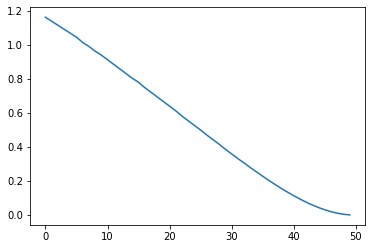

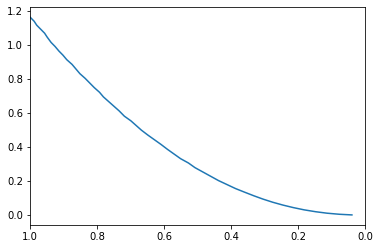

In [8]:
# compare x_t with x_0

x_diffs = []
for step_idx in range(gen_steps):
    start = starts[step_idx]
    x_diffs.append((start - x_0).pow(2).mean())

x_diffs_np = [d.float().cpu().numpy() for d in x_diffs]

plt.plot(x_diffs_np)
plt.show()
plt.plot(np_ts, x_diffs_np)
plt.xlim(1, 0)
plt.show()

In [9]:
# vectorized

In [10]:
x_1 = out_dict["noise"]
x_0 = out_dict["output"]
h,w = out_dict["height"], out_dict["width"]
lh,lw = h//16, w//16


ts = []
starts = []
preds = []

for step_idx in range(gen_steps):
    t = out_dict[f"t_{step_idx}"]
    latents_start = out_dict[f"latents_{step_idx}_start"]
    noise_pred = out_dict[f"noise_pred_{step_idx}"]
    ts.append(t)
    starts.append(latents_start)
    preds.append(noise_pred)

ts = torch.cat(ts)
starts = torch.cat(starts)
preds = torch.cat(preds)

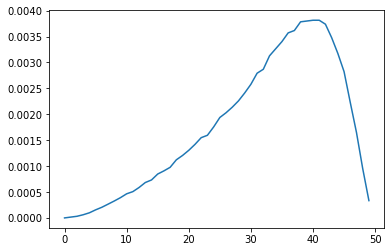

In [11]:
_,L,C = x_0.shape

# full horror (1-ts.view(-1,1,1).expand(-1,L,C))*x_0.expand(gen_steps, -1, -1) + ts.view(-1,1,1).expand(-1,L,C) * x_1.expand(gen_steps, -1, -1)
ts_exp = ts.view(-1,1,1)
x_t_ideals = (1-ts_exp)*x_0 + ts_exp*x_1

x_t_diffs = (x_t_ideals - starts).pow(2).mean(dim=(-1,-2))
plt.plot(x_t_diffs.float())


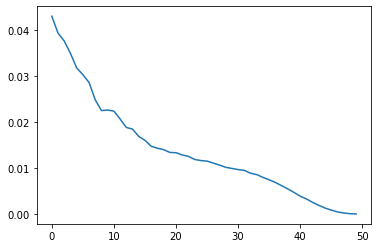

In [12]:
x_0_projs = starts - ts_exp * preds
proj_diffs = (x_0 - x_0_projs).pow(2).mean(dim=(-1,-2))

plt.plot(proj_diffs.float())

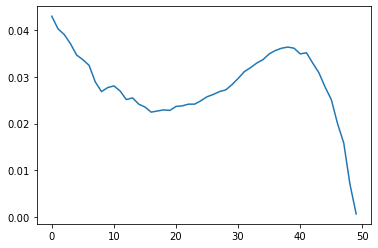

In [13]:
v_ideals = (starts - x_0) / ts_exp
v_diffs = (v_ideals - preds).pow(2).mean(dim=(-1,-2))


plt.plot(v_diffs.float())


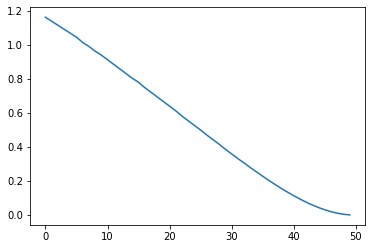

In [14]:
x_diffs = (starts - x_0).pow(2).mean(dim=(-1,-2))

plt.plot(x_diffs.float())

In [15]:
import tqdm

x_t_diffs_all = []
proj_diffs_all = []
v_diffs_all = []
x_diffs_all = []

pow_num = 1

for dpath in tqdm.tqdm(data_paths[:100]):

    out_dict = torch.load(dpath)
    x_1 = out_dict["noise"]
    x_0 = out_dict["output"]
    h,w = out_dict["height"], out_dict["width"]
    lh,lw = h//16, w//16


    ts = []
    starts = []
    preds = []

    for step_idx in range(gen_steps):
        t = out_dict[f"t_{step_idx}"]
        latents_start = out_dict[f"latents_{step_idx}_start"]
        noise_pred = out_dict[f"noise_pred_{step_idx}"]
        ts.append(t)
        starts.append(latents_start)
        preds.append(noise_pred)

    ts = torch.cat(ts)
    starts = torch.cat(starts)
    preds = torch.cat(preds)

    ts_exp = ts.view(-1,1,1)
    x_t_ideals = (1-ts_exp)*x_0 + ts_exp*x_1
    x_t_diffs = (x_t_ideals - starts).pow(pow_num).abs().mean(dim=(-1,-2))
    x_0_projs = starts - ts_exp * preds
    proj_diffs = (x_0 - x_0_projs).pow(pow_num).abs().mean(dim=(-1,-2))
    v_ideals = (starts - x_0) / ts_exp
    v_diffs = (v_ideals - preds).pow(pow_num).abs().mean(dim=(-1,-2))
    x_diffs = (starts - x_0).pow(pow_num).abs().mean(dim=(-1,-2))

    x_t_diffs_all.append(x_t_diffs)
    proj_diffs_all.append(proj_diffs)
    v_diffs_all.append(v_diffs)
    x_diffs_all.append(x_diffs)

x_t_diffs_all = torch.stack(x_t_diffs_all)
proj_diffs_all = torch.stack(proj_diffs_all)
v_diffs_all = torch.stack(v_diffs_all)
x_diffs_all = torch.stack(x_diffs_all)

x_t_diffs_means = torch.mean(x_t_diffs_all, dim=0).float()
proj_diffs_means = torch.mean(proj_diffs_all, dim=0).float()
v_diffs_means = torch.mean(v_diffs_all, dim=0).float()
x_diffs_means = torch.mean(x_diffs_all, dim=0).float()

x_t_diffs_stds = torch.std(x_t_diffs_all, dim=0).float()
proj_diffs_stds = torch.std(proj_diffs_all, dim=0).float()
v_diffs_stds = torch.std(v_diffs_all, dim=0).float()
x_diffs_stds = torch.std(x_diffs_all, dim=0).float()


100%|██████████| 21/21 [00:01<00:00, 17.25it/s]


(1.0, 0.0)

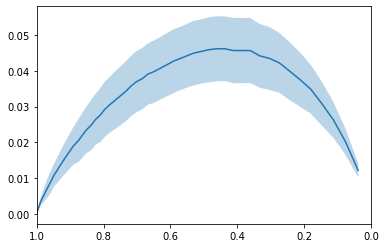

In [16]:


plt.plot(ts.float(), x_t_diffs_means.float())

plt.fill_between(
    ts.float(),
    x_t_diffs_means - x_t_diffs_stds,
    x_t_diffs_means + x_t_diffs_stds,
    alpha=0.3,
    edgecolor='none',
    label='±1 std'
)

plt.xlim(1,0)


(1.0, 0.0)

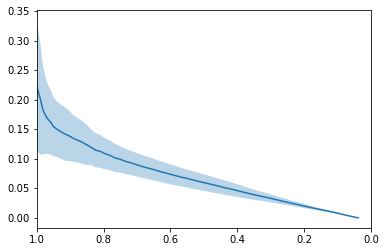

In [17]:


plt.plot(ts.float(), proj_diffs_means.float())

plt.fill_between(
    ts.float(),
    proj_diffs_means - proj_diffs_stds,
    proj_diffs_means + proj_diffs_stds,
    alpha=0.3,
    edgecolor='none',
    label='±1 std'
)

plt.xlim(1,0)


(1.0, 0.0)

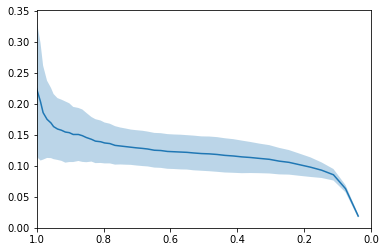

In [18]:


plt.plot(ts.float(), v_diffs_means.float())

plt.fill_between(
    ts.float(),
    v_diffs_means - v_diffs_stds,
    v_diffs_means + v_diffs_stds,
    alpha=0.3,
    edgecolor='none',
    label='±1 std'
)

plt.xlim(1,0)


(0.0, 0.9)

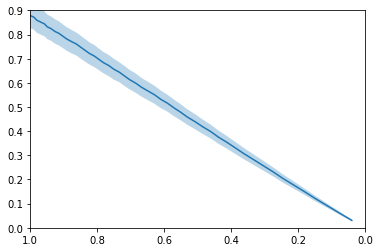

In [19]:


plt.plot(ts.float(), x_diffs_means.float())

plt.fill_between(
    ts.float(),
    x_diffs_means - x_diffs_stds,
    x_diffs_means + x_diffs_stds,
    alpha=0.3,
    edgecolor='none',
    label='±1 std'
)

plt.xlim(1,0)
plt.ylim(0,0.9)


In [20]:
x_0s = []
x_1s = []
for dpath in tqdm.tqdm(data_paths[:100]):
    out_dict = torch.load(dpath)
    x_1 = out_dict["noise"]
    x_0 = out_dict["output"]
    x_1s.append(x_1.squeeze(0))
    x_0s.append(x_0.squeeze(0))

x_0s = torch.cat(x_0s)
x_1s = torch.cat(x_1s)

100%|██████████| 21/21 [00:00<00:00, 45.46it/s]


In [21]:
from qwenimage.debug import texam

texam(x_0s)

Shape: (85932, 64)
Min: -3.484375, Max: 3.265625, Mean: -0.041748046875
Device: cpu, Dtype: torch.bfloat16, Requires Grad: False


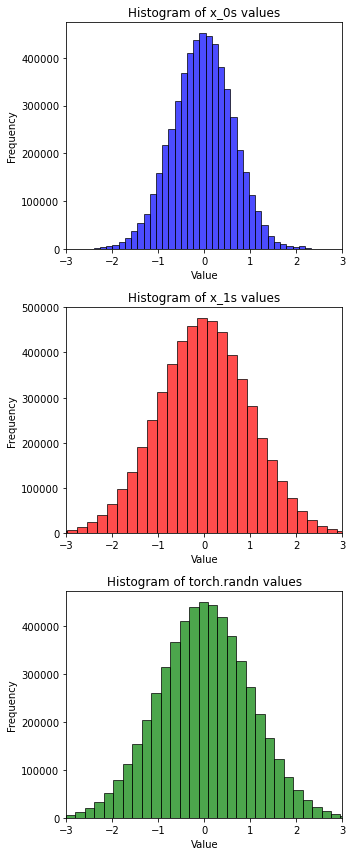

In [22]:
import matplotlib.pyplot as plt

# Create histogram for x_0s, x_1s, and random normal
plt.figure(figsize=(5, 12))

plt.subplot(3, 1, 1)
plt.hist(x_0s.flatten().float().cpu().numpy(), bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of x_0s values')
plt.xlabel('Value')
plt.xlim(-3,3)
plt.ylabel('Frequency')

plt.subplot(3, 1, 2)
plt.hist(x_1s.flatten().float().cpu().numpy(), bins=50, alpha=0.7, color='red', edgecolor='black')
plt.title('Histogram of x_1s values')
plt.xlabel('Value')
plt.xlim(-3,3)
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
random_data = torch.randn(x_0s.shape).flatten().float().cpu().numpy()
plt.hist(random_data, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title('Histogram of torch.randn values')
plt.xlabel('Value')
plt.xlim(-3,3)
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
